Importing is the dataset is with Ben's code:

In [17]:
# Import libraries
import os
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# get data
def setup_data(batch_size: int = 64) -> Tuple[DataLoader, DataLoader, torchvision.datasets.ImageFolder, torchvision.datasets.ImageFolder]:
    """
    Set up data loaders and datasets for training and validation.

    Args:
        batch_size: Number of samples per batch

    Returns:
        train_loader: DataLoader for training
        val_loader: DataLoader for validation
        train_set: Training dataset
        val_set: Validation dataset
    """
    # Download dataset
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    data_dir = pathlib.Path(path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create datasets
    train_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Training'),
        transform=transform
    )
    val_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Testing'),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f'Training samples: {len(train_set)}')
    print(f'Validation samples: {len(val_set)}')
    print(f'Number of classes: {len(train_set.classes)}')
    print(f'Classes: {train_set.classes}')

    return train_loader, val_loader, train_set, val_set

# Set up data loaders
train_loader, val_loader, train_set, val_set = setup_data(batch_size=64)

Using device: cuda
Training samples: 5712
Validation samples: 1311
Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


This is where I defined the CNN, and training it

In [18]:
# This is the CNN definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # convolution
        self.act1 = nn.Tanh() # activation function
        self.pool1 = nn.MaxPool2d(2) # pooling to reduce size

        # second layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolution
        self.act2 = nn.Tanh() # activation function
        self.pool2 = nn.MaxPool2d(2) # pooling to reduce size

        # third layer
        self.fc1 = nn.Linear(8 * 32 * 32, 32)
        self.act3 = nn.Tanh()

        # making correct output
        self.fc2 = nn.Linear(32, 4) # 4 outputs for 3 different tumors and 1 non-tumar

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) # first layer
        out = self.pool2(self.act2(self.conv2(out))) # second layer
        out = out.view(-1, 8 * 32 * 32) # linearize
        out = self.act3(self.fc1(out)) # last layer
        out = self.fc2(out) # making right output
        return out

model = Net()

# counting the number of parameters
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(263628, [144, 16, 1152, 8, 262144, 32, 128, 4])

The training starts here:

In [19]:
import datetime

# the training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, ben = False):
    # this is to use the GPU?
    model = model.to(device)
    if ben:
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # record training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    # loop over epochs
    for epoch in range(1, n_epochs + 1):
        # Training phase
        model.train()
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        train_correct = 0
        train_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += loss_fn(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss = loss_train / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total


        # Update learning rate
        if ben:
            scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        if epoch == 1 or epoch % 10 == 0:
            print(f'Epoch {epoch}/{n_epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

    return history


In [20]:
model_oulin = Net().to(device) # CNN
optimizer = torch.optim.SGD(model_oulin.parameters(), lr=1e-2) # optimizer
loss_fn = nn.CrossEntropyLoss() # loss function
# training starts here
history_oulin = training_loop(n_epochs = 100, optimizer = optimizer, model = model_oulin, loss_fn = loss_fn, train_loader = train_loader)

Epoch 1/100:
Train Loss: 1.0437, Val Loss: 0.9302, Train Accuracy: 71.36%, Val Accuracy: 64.45%
Epoch 10/100:
Train Loss: 0.4068, Val Loss: 0.5451, Train Accuracy: 84.80%, Val Accuracy: 77.50%
Epoch 20/100:
Train Loss: 0.2673, Val Loss: 0.3906, Train Accuracy: 91.35%, Val Accuracy: 83.83%
Epoch 30/100:
Train Loss: 0.1791, Val Loss: 0.2881, Train Accuracy: 95.31%, Val Accuracy: 88.71%
Epoch 40/100:
Train Loss: 0.1250, Val Loss: 0.4319, Train Accuracy: 85.77%, Val Accuracy: 84.36%
Epoch 50/100:
Train Loss: 0.0836, Val Loss: 0.2123, Train Accuracy: 98.27%, Val Accuracy: 92.83%
Epoch 60/100:
Train Loss: 0.0575, Val Loss: 0.2058, Train Accuracy: 98.46%, Val Accuracy: 93.06%
Epoch 70/100:
Train Loss: 0.0437, Val Loss: 0.1742, Train Accuracy: 99.47%, Val Accuracy: 94.66%
Epoch 80/100:
Train Loss: 0.0315, Val Loss: 0.1901, Train Accuracy: 99.35%, Val Accuracy: 93.67%
Epoch 90/100:
Train Loss: 0.0243, Val Loss: 0.1652, Train Accuracy: 99.81%, Val Accuracy: 95.04%
Epoch 100/100:
Train Loss: 0.01

Also load Ben's CNN, and compare after 100 Epochs

In [21]:
class BrainTumorCNN(nn.Module):
    """
    CNN architecture for brain tumor classification.

    Architecture:
    - 4 convolutional blocks (each with Conv2d, BatchNorm2d, LeakyReLU, MaxPool2d)
    - 2 fully connected layers with dropout
    """
    def __init__(self, num_classes: int = 4):
        super(BrainTumorCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),  # Add dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize model
model_ben = BrainTumorCNN().to(device)
print(model_ben)
# counting the number of parameters
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [22]:
history_ben = training_loop(n_epochs = 100, optimizer = optimizer, model = model_ben, loss_fn = loss_fn, train_loader = train_loader, ben = True)

Epoch 1/100:
Train Loss: 0.7190, Val Loss: 0.5521, Train Accuracy: 85.22%, Val Accuracy: 76.74%
Epoch 10/100:
Train Loss: 0.0814, Val Loss: 0.1820, Train Accuracy: 96.39%, Val Accuracy: 93.75%
Epoch 20/100:
Train Loss: 0.0117, Val Loss: 0.0699, Train Accuracy: 99.89%, Val Accuracy: 97.71%
Epoch 30/100:
Train Loss: 0.0116, Val Loss: 0.0704, Train Accuracy: 99.91%, Val Accuracy: 98.25%
Epoch 40/100:
Train Loss: 0.0018, Val Loss: 0.0629, Train Accuracy: 100.00%, Val Accuracy: 98.47%
Epoch 50/100:
Train Loss: 0.0002, Val Loss: 0.0835, Train Accuracy: 100.00%, Val Accuracy: 98.25%
Epoch 60/100:
Train Loss: 0.0001, Val Loss: 0.0705, Train Accuracy: 100.00%, Val Accuracy: 98.55%
Epoch 70/100:
Train Loss: 0.0003, Val Loss: 0.0800, Train Accuracy: 100.00%, Val Accuracy: 98.25%
Epoch 80/100:
Train Loss: 0.0001, Val Loss: 0.0774, Train Accuracy: 100.00%, Val Accuracy: 98.32%
Epoch 90/100:
Train Loss: 0.0001, Val Loss: 0.0775, Train Accuracy: 100.00%, Val Accuracy: 98.32%
Epoch 100/100:
Train Loss

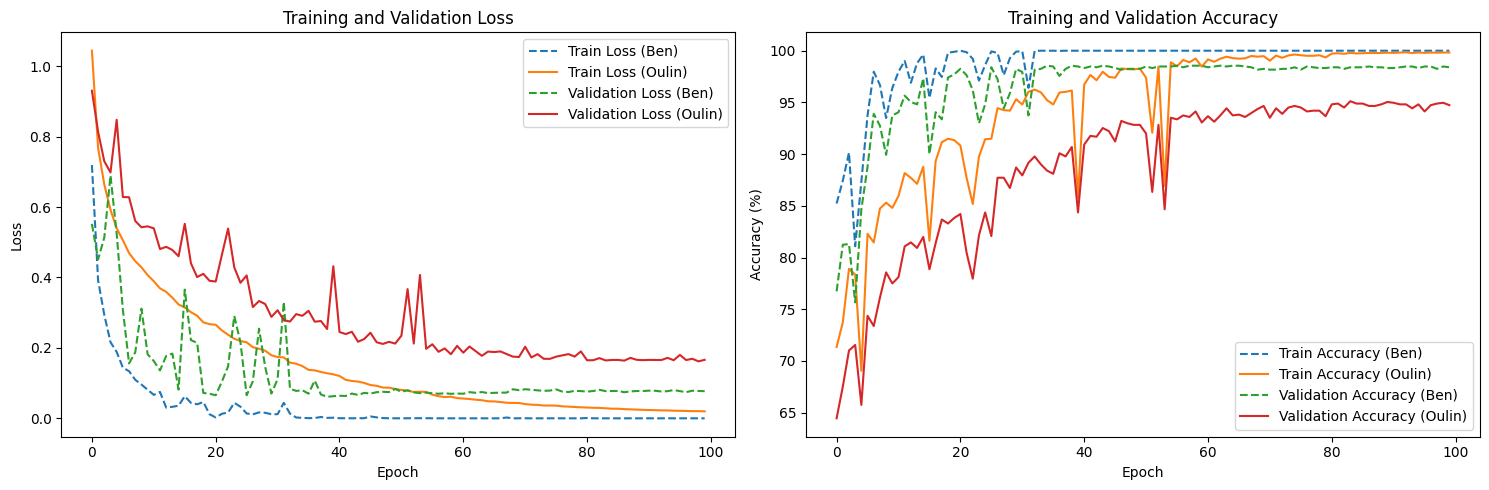

In [23]:
def plot_training_history(history: Dict[str, List[float]], history2: Dict[str, List[float]]):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], '--', label='Train Loss (Ben)')
    ax1.plot(history2['train_loss'], label='Train Loss (Oulin)')
    ax1.plot(history['val_loss'], '--', label='Validation Loss (Ben)')
    ax1.plot(history2['val_loss'], label='Validation Loss (Oulin)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_accuracy'], '--', label='Train Accuracy (Ben)')
    ax2.plot(history2['train_accuracy'], label='Train Accuracy (Oulin)')
    ax2.plot(history['val_accuracy'], '--', label='Validation Accuracy (Ben)')
    ax2.plot(history2['val_accuracy'], label='Validation Accuracy (Oulin)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_ben, history_oulin)

Let's check the training set accuracy

In [2]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                #print(imgs, labels)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [25]:
validate(model_ben, train_loader, val_loader) #running the validation

Accuracy Training: 1.00
Accuracy Validation: 0.98


In [3]:
validate(model_oulin, train_loader, val_loader) #running the validation

NameError: name 'model_oulin' is not defined